<a href="https://colab.research.google.com/github/eminshall/QuantFinanceWorkbooks/blob/main/Deep_Learning_Predict_Market_Direction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Grab Data
import yfinance as yf

#Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
#USD/EUR price levels for the past 10 years
symbol = 'EUR=X'
raw = yf.download(symbol, start="2013-01-01", end="2023-02-28")['Adj Close']

data = pd.DataFrame(raw)

[*********************100%***********************]  1 of 1 completed


In [3]:
#Calculate the returns and add it to the DataFrame
data['return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

#When the market direction is greater than 0 --> classify 1, less than 0 --> 0
data['direction'] = np.where(data['return'] > 0, 1, 0)

data.head()

,Adj Close,return,direction
Date,,,
2013-01-01,0.75750,NaN,0
2013-01-02,0.75770,0.000264,1
2013-01-03,0.75860,0.001187,1
2013-01-04,0.76730,0.011403,1
2013-01-07,0.76526,-0.002662,0


In [4]:
#Create 5 columns for each lag representing previous day's return
lags = 5

cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  data[col] = data['return'].shift(lag)
  cols.append(col)

data.dropna(inplace=True)

In [5]:
data.round(4).tail()

,Adj Close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2023-02-21,0.9361,0.0002,1,-0.0018,0.0024,0.0041,-0.0005,-0.0049
2023-02-22,0.9388,0.0029,1,0.0002,-0.0018,0.0024,0.0041,-0.0005
2023-02-23,0.9429,0.0043,1,0.0029,0.0002,-0.0018,0.0024,0.0041
2023-02-24,0.9436,0.0007,1,0.0043,0.0029,0.0002,-0.0018,0.0024
2023-02-27,0.9474,0.0041,1,0.0007,0.0043,0.0029,0.0002,-0.0018


# Deep Neural Network Stuff

In [12]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
import random

In [13]:
optimizer = Adam(learning_rate=0.0001)

def set_seeds(seed=100):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(100)

In [14]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
train_set, test_set = np.split(data, [int(.70 *len(data))])

In [16]:
mu, std = train_set.mean(), train_set.std()

In [17]:
# Normalizes the features data by Gaussian normalization
training_data_ = (train_set - mu) / std
test_data_ = (test_set - mu) / std

In [19]:
%%time
model.fit(train_set[cols],
           train_set['direction'],
           epochs=50, verbose=False,
           validation_split=0.2, shuffle=False)

CPU times: user 8.8 s, sys: 475 ms, total: 9.28 s
Wall time: 9.04 s


In [20]:
res = pd.DataFrame(model.history.history)

<Axes: >

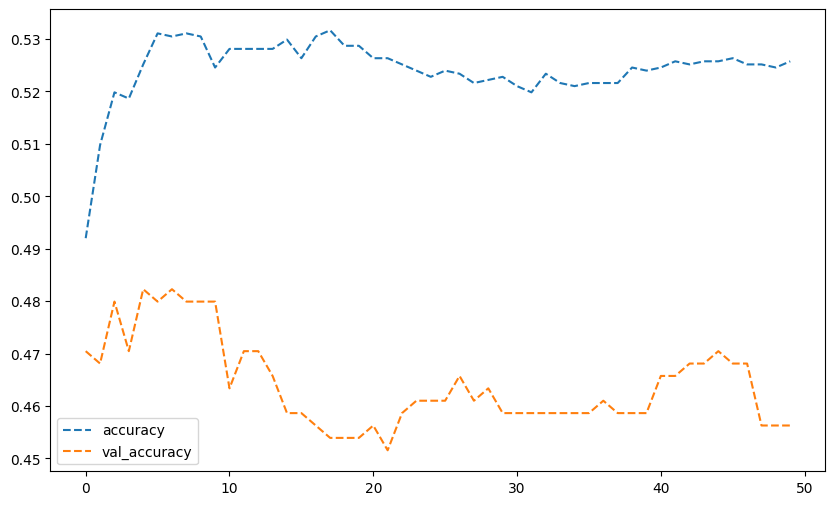

In [21]:
# Accuracy of the model for training and validation in the training set
res[['accuracy', 'val_accuracy']].plot(figsize=(10,6), style='--')

In [22]:
model.evaluate(training_data_[cols], train_set['direction'])

66/66 [==============================] - 0s 3ms/step - loss: 1.0292 - accuracy: 0.5085


[1.0292057991027832, 0.5085227489471436]

In [23]:
# Creating Prediction of market direction
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

66/66 [==============================] - 0s 2ms/step


In [ ]:
pred

In [24]:
pred[:30].flatten()

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0])

In [25]:
# Transforming the predictions to long-short position; 1,-1
train_set['prediction'] = np.where(pred > 0, 1, -1)

In [27]:
# Calculate strategy returns given the positions
train_set['strategy'] = (train_set['prediction'] * train_set['return'])

In [28]:
train_set[['return', 'strategy']].sum().apply(np.exp)

return      1.085392
strategy    1.393609
dtype: float64

<Axes: xlabel='Date'>

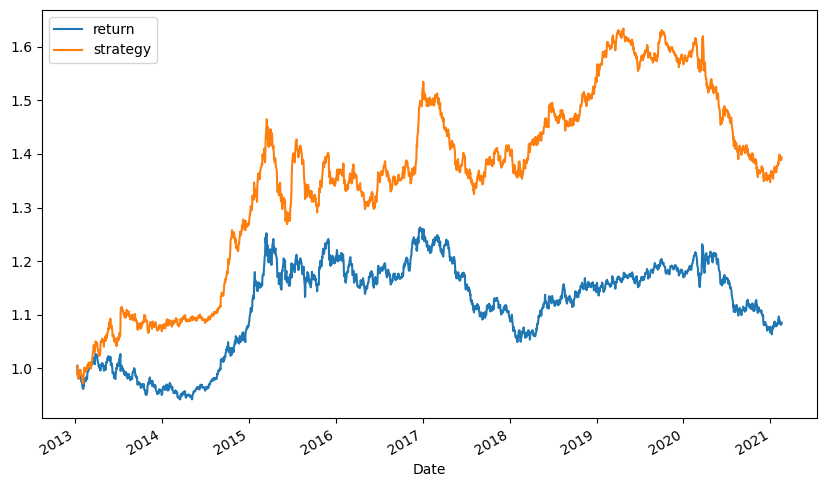

In [29]:
# Plots the strategy returns to the benchmark performance for the sample
train_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

# Same Process on the Out-of-Sample Test Set

In [30]:
model.evaluate(test_data_[cols], test_set['direction'])

17/17 [==============================] - 0s 3ms/step - loss: 1.0492 - accuracy: 0.5057


[1.0491758584976196, 0.5056818127632141]

In [31]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

17/17 [==============================] - 0s 2ms/step


In [32]:
test_set['prediction'] = np.where(pred > 0, 1, -1)

In [33]:
test_set['prediction'].value_counts()

 1    411
-1    117
Name: prediction, dtype: int64

In [34]:
test_set['strategy'] = (test_set['prediction'] * test_set['return'])

In [36]:
test_set[['return', 'strategy']].sum().apply(np.exp)

return      1.145690
strategy    0.997031
dtype: float64

<Axes: xlabel='Date'>

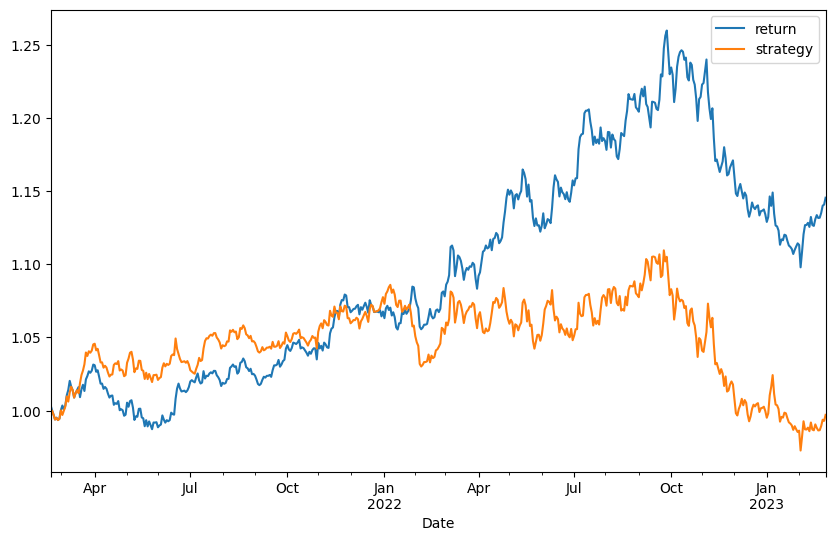

In [38]:
test_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

# Adding More Features

In [39]:
#Add momentum, volatitlity, & distance to the data_frame
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['Adj Close'] - data['Adj Close'].rolling(50).mean()).shift(1)

In [42]:
data.dropna(inplace=True)

In [43]:
cols.extend(['momentum', 'volatility', 'distance'])

In [45]:
# New DataFrame
data.round(4).tail()

,Adj Close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,
2023-02-21,0.9361,0.0002,1,-0.0018,0.0024,0.0041,-0.0005,-0.0049,-0.0001,0.0053,0.0039
2023-02-22,0.9388,0.0029,1,0.0002,-0.0018,0.0024,0.0041,-0.0005,0.0009,0.0053,0.0043
2023-02-23,0.9429,0.0043,1,0.0029,0.0002,-0.0018,0.0024,0.0041,0.0016,0.0053,0.0070
2023-02-24,0.9436,0.0007,1,0.0043,0.0029,0.0002,-0.0018,0.0024,0.0016,0.0053,0.0110
2023-02-27,0.9474,0.0041,1,0.0007,0.0043,0.0029,0.0002,-0.0018,0.0013,0.0053,0.0116


In [46]:
# Refit and train/test
train_data, test_data = np.split(data, [int(.70 *len(data))])
mu, std = train_data.mean(), train_data.std()

In [47]:
training_data_ = (train_data - mu) / std
test_data_ = (test_data - mu) / std

In [52]:
# Update Dense Layers to 32
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [54]:
%%time
model.fit(training_data_[cols],
           train_data['direction'],
           epochs=25, verbose=False,
           validation_split=0.2, shuffle=False)

CPU times: user 5.13 s, sys: 209 ms, total: 5.34 s
Wall time: 6.26 s


In [55]:
model.evaluate(training_data_[cols], train_data['direction'])

65/65 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.5584


[0.684630811214447, 0.5583977103233337]

In [56]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

65/65 [==============================] - 0s 3ms/step


In [57]:
train_data['prediction'] = np.where(pred > 0, 1, -1)

In [58]:
train_data['strategy'] = (train_data['prediction'] * train_data['return'])

In [61]:
train_data[['return', 'strategy']].sum().apply(np.exp)

return      1.07112
strategy    2.45910
dtype: float64

<Axes: xlabel='Date'>

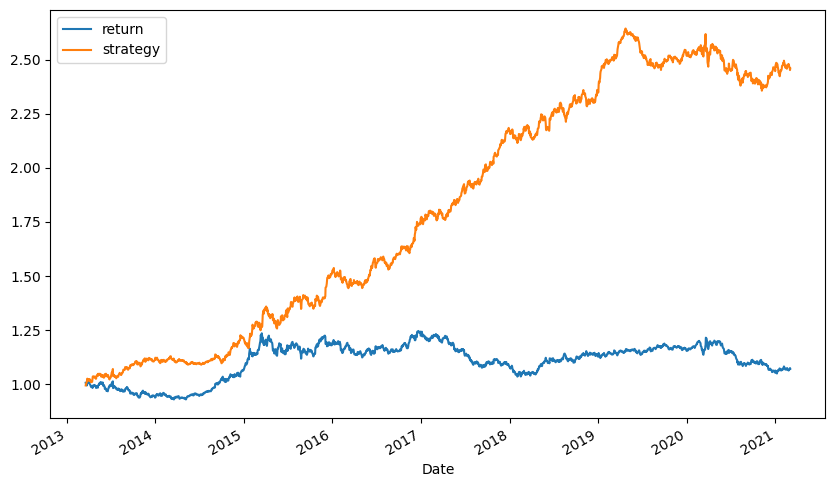

In [62]:
train_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

With additional features we see significantly better results, but let's test it against the out-of-sample test set

## Test Set Prediction

In [63]:
model.evaluate(test_data_[cols], test_data['direction'])

17/17 [==============================] - 0s 6ms/step - loss: 0.6998 - accuracy: 0.5154


[0.6997832655906677, 0.5154440402984619]

In [64]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

17/17 [==============================] - 0s 1ms/step


In [65]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [66]:
test_set['prediction'].value_counts()

 1    411
-1    117
Name: prediction, dtype: int64

In [67]:
test_set['strategy'] = (test_set['prediction'] * test_set['return'])

In [68]:
test_set[['return', 'strategy']].sum().apply(np.exp)

return      1.145690
strategy    0.997031
dtype: float64

<Axes: xlabel='Date'>

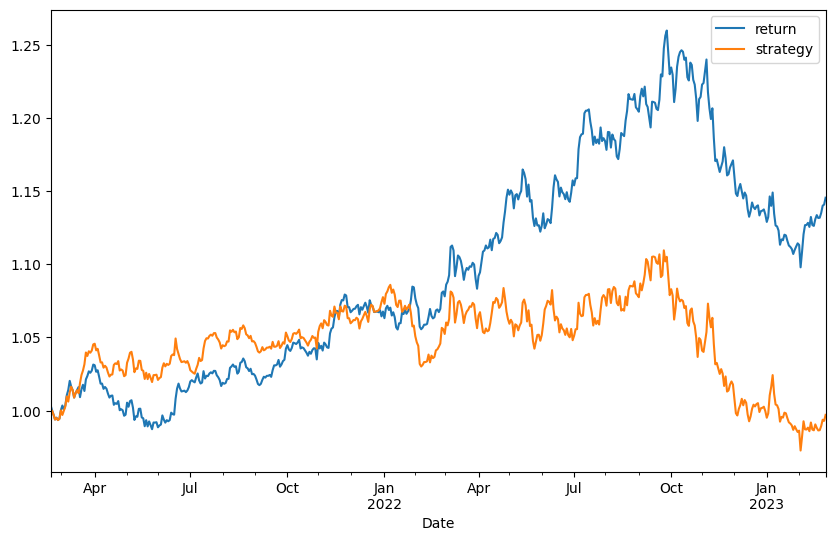

In [69]:
test_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))